# Create Renewable Energy Zones mask

In [1]:
import xarray as xr
import numpy as np
import geopandas
import fiona
import regionmask

https://aemo.com.au/-/media/files/major-publications/isp/2024/appendices/a3-renewable-energy-zones.pdf?la=en

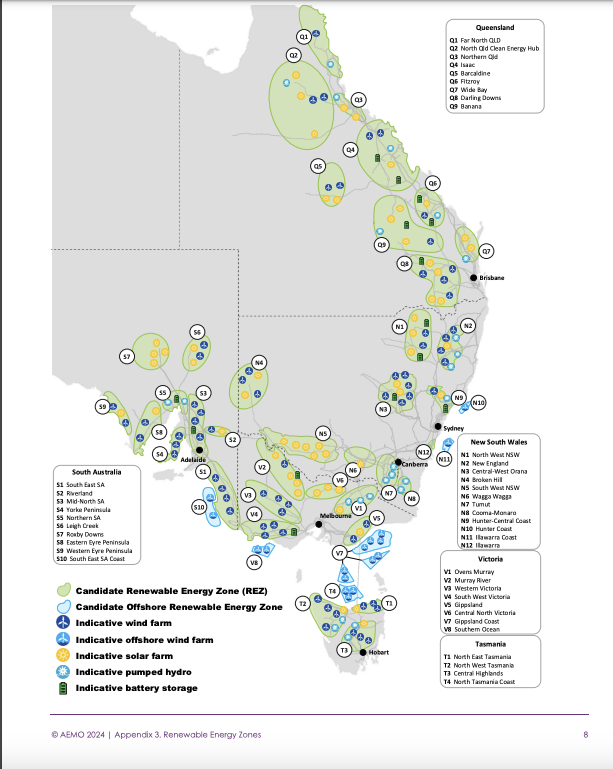

In [2]:
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [18]:
rez_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/data/REZ/2024/Indicative_REZ_boundaries_2024_GIS_data.kml",
    driver="KML"
)

In [19]:
rez_gpd

,Name,Description,geometry
0,Q1 Far North QLD,REZ,"POLYGON Z ((146.13492 -17.65256 0.00000, 146.0..."
1,Q2 North Qld Clean Energy Hub,REZ,"POLYGON Z ((143.72015 -16.97938 0.00000, 143.5..."
2,Q3 Northern Qld,REZ,"POLYGON Z ((146.27782 -18.71920 0.00000, 146.2..."
3,Q4 Isaac,REZ,"POLYGON Z ((147.64366 -19.94015 0.00000, 147.5..."
4,Q5 Barcaldine,REZ,"POLYGON Z ((145.82086 -23.84279 0.00000, 145.9..."
5,Q6 Fitzroy,REZ,"POLYGON Z ((149.95860 -24.15382 0.00000, 149.9..."
6,Q7 Wide Bay,REZ,"POLYGON Z ((152.27090 -25.06574 0.00000, 152.2..."
7,Q8 Darling Downs,REZ,"POLYGON Z ((150.85197 -26.29194 0.00000, 150.7..."
8,Q9 Banana,REZ,"POLYGON Z ((149.13813 -23.31492 0.00000, 148.9..."
9,N1 North West NSW,REZ,"POLYGON Z ((149.63862 -28.78058 0.00000, 149.5..."


In [20]:
# Add central coords of REZ regions
rez_gpd['coords'] = rez_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
rez_gpd['coords'] = [coords[0] for coords in rez_gpd['coords']]

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


We code each region according to the type of renewables (exlude pumped hydro):

1. Onshore wind
2. Solar
3. Onshore Wind and solar
4. Offshore wind
5. None

In [21]:
# Add column of energy type codes by matching AEMO document with numeric code
# https://aemo.com.au/-/media/files/major-publications/isp/2024/appendices/a3-renewable-energy-zones.pdf
# Use currently installed for codes
region_codes_current = [
    1, 3, 2, 3, 2, 2, 2, 3, 5, # QLD
    2, 3, 3, 3, 2, 2, 1, 1, 5, 5, 5, 5, # NSW
    5, 2, 3, 1, 2, 2, 5, 5, # VIC
    3, 2, 1, 1, 3, 5, 5, 1, 5, 5, # SA
    1, 1, 1, 5 # TAS
    
]

In [22]:
region_codes_SC2050 = [
    1, 3, 2, 3, 3, 3, 3, 3, 5, # QLD
    2, 3, 3, 3, 3, 2, 1, 1, 3, 4, 5, 5, # NSW
    2, 2, 3, 1, 3, 2, 5, 4, # VIC
    3, 2, 1, 1, 3, 5, 2, 1, 5, 5, # SA
    1, 1, 1, 5 # TAS
    
]

In [23]:
rez_gpd['code_2023'] = region_codes_current

In [24]:
rez_gpd['code_SC2050'] = region_codes_SC2050

In [25]:
# geopandas can't have a tuple, so split coords into lon and lat columns
rez_gpd["longitude"] = [rez_gpd.iloc[i]["coords"][0] for i in range(len(rez_gpd))]
rez_gpd["latitude"] = [rez_gpd.iloc[i]["coords"][-1] for i in range(len(rez_gpd))]

In [26]:
rez_gpd = rez_gpd.drop(columns="coords")

In [27]:
# And rename columns that are longer than 10 characters
cols = np.array(rez_gpd.columns)
cols[1] = "Type"
rez_gpd.columns = cols

In [28]:
rez_gpd.head()

,Name,Type,geometry,code_2023,code_SC2050,longitude,latitude
0,Q1 Far North QLD,REZ,"POLYGON Z ((146.13492 -17.65256 0.00000, 146.0...",1,1,145.123721,-16.187650
1,Q2 North Qld Clean Energy Hub,REZ,"POLYGON Z ((143.72015 -16.97938 0.00000, 143.5...",3,3,144.062266,-19.110858
2,Q3 Northern Qld,REZ,"POLYGON Z ((146.27782 -18.71920 0.00000, 146.2...",2,2,146.333143,-19.197589
3,Q4 Isaac,REZ,"POLYGON Z ((147.64366 -19.94015 0.00000, 147.5...",3,3,148.339869,-21.393793
4,Q5 Barcaldine,REZ,"POLYGON Z ((145.82086 -23.84279 0.00000, 145.9...",2,3,145.595326,-22.855731


In [29]:
# Save as shapefile
rez_gpd.to_file(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/resource_coded_Indicative_REZ_boundaries_2024_GIS_data.shp",
    # driver="ESRI shapefile"
)

/jobfs/141525447.gadi-pbs/ipykernel_3080085/927834818.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  rez_gpd.to_file(


##### Create region mask

In [15]:
def create_mask(gpd_df, template_ds, boundary=None, lon_name='longitude', lat_name='latitude'):
    """
    Create mask from shapefiles and a template xarray dataArray or dataset.
    """
    mask = regionmask.mask_3D_geopandas(
        gpd_df,
        template_ds[lon_name],
        template_ds[lat_name]
    )
    
    if lon_name != 'lon':
        mask = mask.rename({lon_name: 'lon'})
    if lat_name != 'lat':
        mask = mask.rename({lat_name: 'lat'})
        
    if isinstance(boundary, list):
        mask = mask.sel(
            lon=slice(boundary[0], boundary[1]),
            lat=slice(boundary[2], boundary[3])
        )
        
    return mask

In [16]:
rez_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/resource_coded_Indicative_REZ_boundaries_2024_GIS_data.shp"
)

In [17]:
era5_instance = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/2011/2t_era5_moda_sfc_20110101-20110131.nc"
)

In [18]:
rez_mask = create_mask(
    rez_gpd,
    era5_instance,
    [110, 155, -10, -45]
)

In [19]:
rez_codes = rez_gpd['Name']
rez_codes = [i.split(" ")[0] for i in rez_codes]
rez_mask = rez_mask.assign_coords({
    'region': rez_codes
})

In [20]:
rez_gpd.head()

,Name,Type,code,longitude,latitude,geometry
0,Q1 Far North QLD,REZ,5,145.123721,-16.187650,"POLYGON Z ((146.13492 -17.65256 0.00000, 146.0..."
1,Q2 North Qld Clean Energy Hub,REZ,7,144.062266,-19.110858,"POLYGON Z ((143.72015 -16.97938 0.00000, 143.8..."
2,Q3 Northern Qld,REZ,6,146.333143,-19.197589,"POLYGON Z ((146.27782 -18.71920 0.00000, 146.2..."
3,Q4 Isaac,REZ,7,148.339869,-21.393793,"POLYGON Z ((147.64366 -19.94015 0.00000, 147.6..."
4,Q5 Barcaldine,REZ,3,145.595326,-22.855731,"POLYGON Z ((145.82086 -23.84279 0.00000, 145.7..."


In [21]:
# Assign coordinates to each region for the resource code, latitude and longitude
rez_mask = rez_mask.assign_coords(
    region_code=("region", region_codes),
    latitude=("region", rez_gpd["latitude"]),
    longitude=("region", rez_gpd["longitude"])
)

In [22]:
rez_mask_ds = rez_mask.to_dataset(name='REZ')
rez_mask_ds.to_netcdf('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc')